In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
    

In [4]:
import json
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, logging
import matplotlib.pyplot as plt

In [17]:
# Load dataset from a JSON file
with open('sentences_data.json', 'r') as f:
    sentences_data_test = json.load(f)

# Convert to Hugging Face dataset
data = Dataset.from_list(sentences_data_test)

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create a DatasetDict object to hold the training and testing datasets
dataset = DatasetDict({"train": Dataset.from_dict(train_data), "test": Dataset.from_dict(test_data)})

# Function to tokenize the dataset
def tokenize_function(examples, tokenizer):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

# Function to compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    logits = predictions[0]
    preds = logits.argmax(-1)
    accuracy = (preds == labels).astype(float).mean().item()
    return {"accuracy": accuracy}

In [11]:
# Function to train and evaluate the model
def train_and_evaluate_model(model_name, tokenizer_name=None):
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name or model_name)

    # Add padding token if not present
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    logging.set_verbosity_error()

    # Load the pre-trained model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.resize_token_embeddings(len(tokenizer))

    # Set pad token id
    if model.config.pad_token_id is None:
        model.config.pad_token_id = tokenizer.pad_token_id

    # Tokenize the dataset
    tokenized_datasets = dataset.map(lambda examples: tokenize_function(examples, tokenizer), batched=True)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name}",
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        save_strategy="epoch",
        logging_strategy = "epoch"
    )

    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    train_result = trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Evaluation results for {model_name}: {eval_results}")

    training_loss_history = trainer.state.log_history


     # Plot training and validation loss
    training_loss = [log['loss'] for log in training_loss_history if 'loss' in log]
    epochs = range(1, len(training_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, training_loss, 'b', label='Training loss')
    plt.plot(epochs, [eval_results['eval_loss']] * len(training_loss), 'r', label='Validation loss')
    plt.title(f'Training and validation loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

{'loss': 0.7069, 'grad_norm': 5.755312919616699, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}
{'eval_loss': 0.6680945754051208, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 10.3163, 'eval_samples_per_second': 9.596, 'eval_steps_per_second': 0.679, 'epoch': 1.0}
{'loss': 0.6444, 'grad_norm': 5.101912975311279, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}
{'eval_loss': 0.5945584177970886, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 10.4593, 'eval_samples_per_second': 9.465, 'eval_steps_per_second': 0.669, 'epoch': 2.0}
{'loss': 0.5709, 'grad_norm': 7.803464889526367, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.5740059614181519, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 10.7964, 'eval_samples_per_second': 9.17, 'eval_steps_per_second': 0.648, 'epoch': 3.0}
{'train_runtime': 581.9442, 'train_samples_per_second': 2.041, 'train_steps_per_second': 0.129, 'train_loss': 0.6407637151082357, 'epoch': 3.0}
{'eval_loss': 0.5740059614181519, 'ev

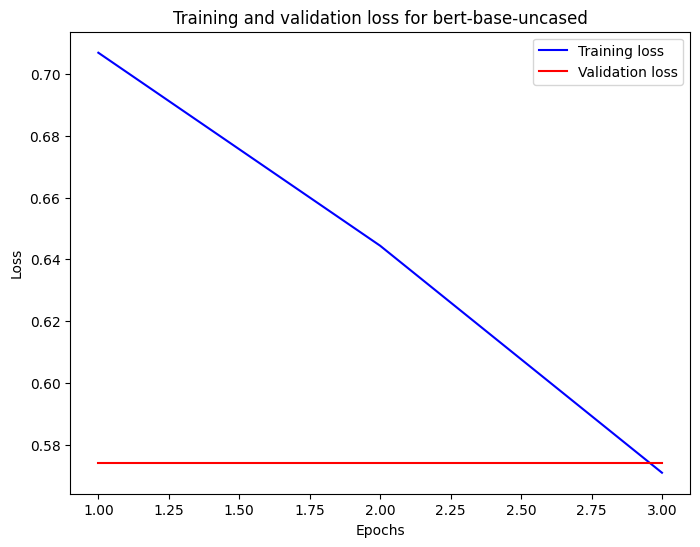

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

{'loss': 0.6963, 'grad_norm': 3.495361089706421, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}
{'eval_loss': 0.6645107865333557, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 10.9447, 'eval_samples_per_second': 9.045, 'eval_steps_per_second': 0.64, 'epoch': 1.0}
{'loss': 0.6606, 'grad_norm': 9.859458923339844, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}
{'eval_loss': 0.6410773992538452, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 10.4483, 'eval_samples_per_second': 9.475, 'eval_steps_per_second': 0.67, 'epoch': 2.0}
{'loss': 0.5851, 'grad_norm': 8.458796501159668, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.6045398116111755, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 11.078, 'eval_samples_per_second': 8.937, 'eval_steps_per_second': 0.632, 'epoch': 3.0}
{'train_runtime': 478.8261, 'train_samples_per_second': 2.481, 'train_steps_per_second': 0.157, 'train_loss': 0.6473340606689453, 'epoch': 3.0}
{'eval_loss': 0.6045398116111755, 'eval

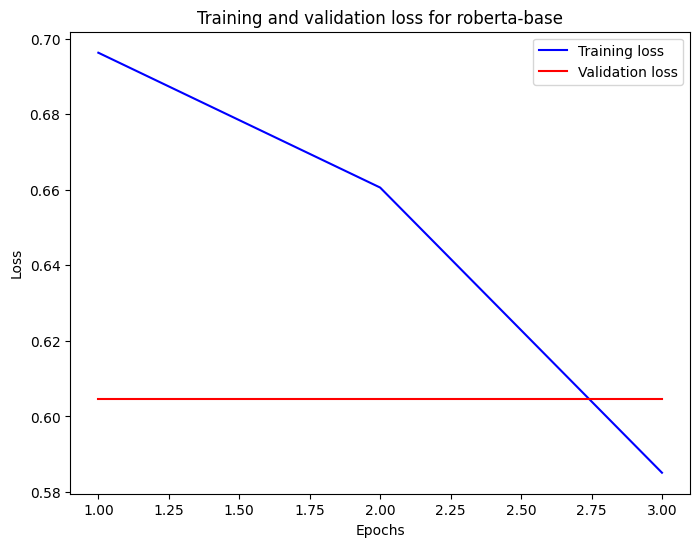

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

{'loss': 0.6881, 'grad_norm': 2.29194712638855, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}
{'eval_loss': 0.6734305620193481, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 6.1091, 'eval_samples_per_second': 16.205, 'eval_steps_per_second': 1.146, 'epoch': 1.0}
{'loss': 0.6421, 'grad_norm': 4.6955084800720215, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}
{'eval_loss': 0.6613572239875793, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 6.2364, 'eval_samples_per_second': 15.875, 'eval_steps_per_second': 1.122, 'epoch': 2.0}
{'loss': 0.5882, 'grad_norm': 4.635076522827148, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.6484998464584351, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 5.9811, 'eval_samples_per_second': 16.552, 'eval_steps_per_second': 1.17, 'epoch': 3.0}
{'train_runtime': 244.1455, 'train_samples_per_second': 4.866, 'train_steps_per_second': 0.307, 'train_loss': 0.6394527053833008, 'epoch': 3.0}
{'eval_loss': 0.6484998464584351, 'ev

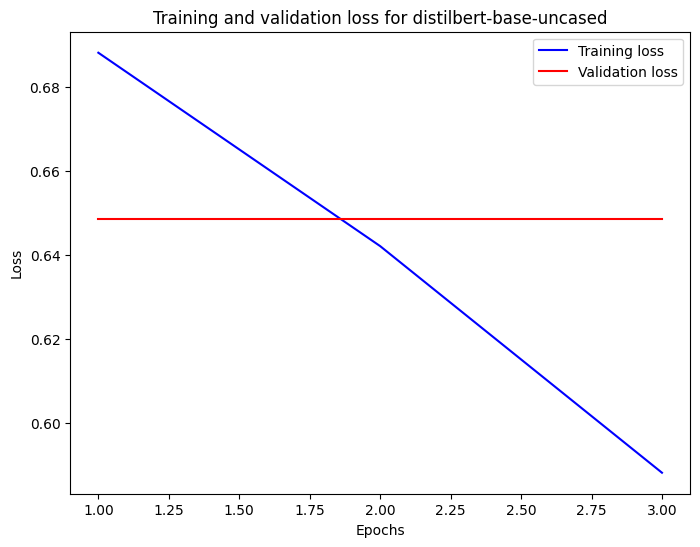

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

{'loss': 0.6873, 'grad_norm': 13.055915832519531, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}
{'eval_loss': 0.6459746956825256, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 11.3096, 'eval_samples_per_second': 8.754, 'eval_steps_per_second': 0.619, 'epoch': 1.0}
{'loss': 0.5703, 'grad_norm': 85.06354522705078, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}
{'eval_loss': 0.759205162525177, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 11.2626, 'eval_samples_per_second': 8.79, 'eval_steps_per_second': 0.622, 'epoch': 2.0}
{'loss': 0.4831, 'grad_norm': 17.52128028869629, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.6343262195587158, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 12.4606, 'eval_samples_per_second': 7.945, 'eval_steps_per_second': 0.562, 'epoch': 3.0}
{'train_runtime': 436.6076, 'train_samples_per_second': 2.721, 'train_steps_per_second': 0.172, 'train_loss': 0.5802334340413412, 'epoch': 3.0}
{'eval_loss': 0.6343262195587158, 'ev

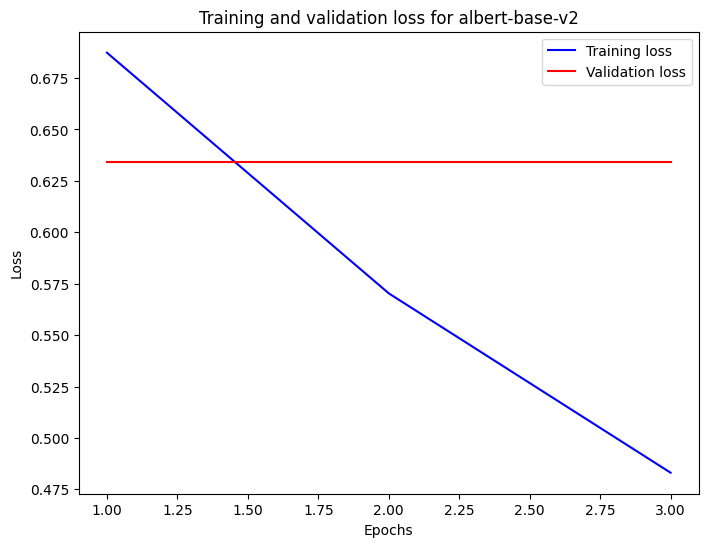

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

{'loss': 0.6943, 'grad_norm': 15.466794967651367, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}
{'eval_loss': 0.6659238934516907, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 13.3601, 'eval_samples_per_second': 7.41, 'eval_steps_per_second': 0.524, 'epoch': 1.0}
{'loss': 0.6677, 'grad_norm': 17.879600524902344, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}
{'eval_loss': 0.669002890586853, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 13.4349, 'eval_samples_per_second': 7.369, 'eval_steps_per_second': 0.521, 'epoch': 2.0}
{'loss': 0.6577, 'grad_norm': 18.995880126953125, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.6705089807510376, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 14.2576, 'eval_samples_per_second': 6.944, 'eval_steps_per_second': 0.491, 'epoch': 3.0}
{'train_runtime': 657.0338, 'train_samples_per_second': 1.808, 'train_steps_per_second': 0.114, 'train_loss': 0.6732205454508463, 'epoch': 3.0}
{'eval_loss': 0.6659238934516907, '

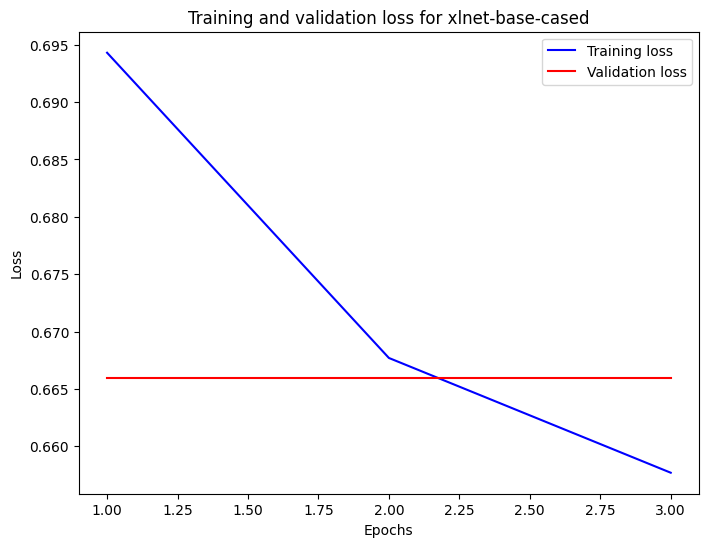

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

{'loss': 0.6868, 'grad_norm': 1.3983089923858643, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}
{'eval_loss': 0.6676861047744751, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 1.8679, 'eval_samples_per_second': 53.001, 'eval_steps_per_second': 3.748, 'epoch': 1.0}
{'loss': 0.6696, 'grad_norm': 1.453871250152588, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}
{'eval_loss': 0.6515412926673889, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 1.7919, 'eval_samples_per_second': 55.25, 'eval_steps_per_second': 3.907, 'epoch': 2.0}
{'loss': 0.6567, 'grad_norm': 1.8464596271514893, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.6471620202064514, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 1.7809, 'eval_samples_per_second': 55.59, 'eval_steps_per_second': 3.931, 'epoch': 3.0}
{'train_runtime': 74.1385, 'train_samples_per_second': 16.024, 'train_steps_per_second': 1.012, 'train_loss': 0.6710372161865235, 'epoch': 3.0}
{'eval_loss': 0.6471620202064514, 'e

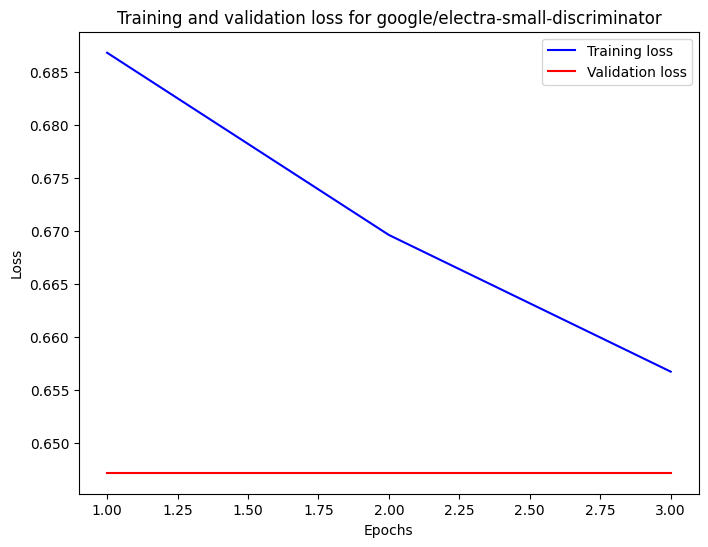

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

{'loss': 0.6851, 'grad_norm': 18.208465576171875, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}
{'eval_loss': 0.6757351756095886, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 6.2192, 'eval_samples_per_second': 15.918, 'eval_steps_per_second': 1.126, 'epoch': 1.0}
{'loss': 0.6736, 'grad_norm': 3.285588264465332, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}
{'eval_loss': 0.6735492944717407, 'eval_accuracy': 0.6161616161616161, 'eval_runtime': 6.551, 'eval_samples_per_second': 15.112, 'eval_steps_per_second': 1.069, 'epoch': 2.0}
{'loss': 0.667, 'grad_norm': 5.065814971923828, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.6733053922653198, 'eval_accuracy': 0.6161616161616161, 'eval_runtime': 7.0133, 'eval_samples_per_second': 14.116, 'eval_steps_per_second': 0.998, 'epoch': 3.0}
{'train_runtime': 281.7364, 'train_samples_per_second': 4.217, 'train_steps_per_second': 0.266, 'train_loss': 0.6752086385091146, 'epoch': 3.0}
{'eval_loss': 0.6733053922653198, 'ev

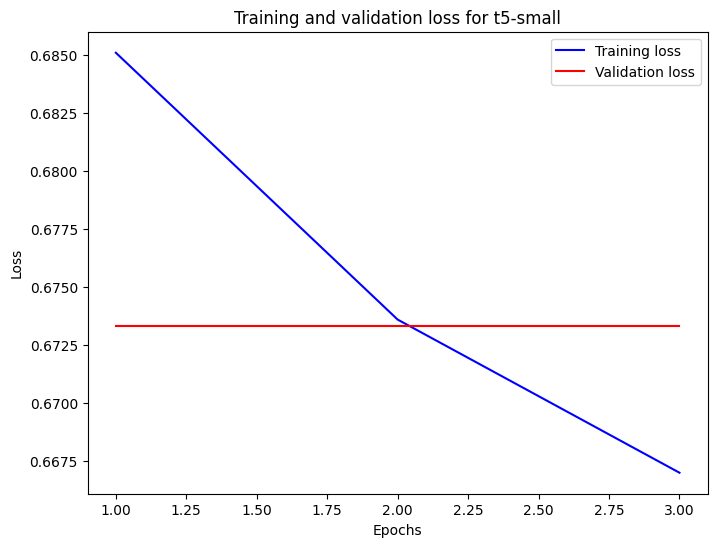

In [18]:
# List of model names to be used for training and evaluation
model_names = [
    "bert-base-uncased",
    "roberta-base",
    "distilbert-base-uncased",
    "albert-base-v2",
    "xlnet-base-cased",
    "google/electra-small-discriminator",
    "t5-small"
]

# Train and evaluate each model in the list
for model_name in model_names:
    train_and_evaluate_model(model_name)